In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import xarray as xr
import rasterio as rio
import rioxarray
import pandas as pd

import deep_snow.models
import deep_snow.dataset
from deep_snow.utils import calc_norm, undo_norm, db_scale, calc_dowy
from deep_snow.dataset import norm_dict

In [2]:
# path to test tiles
test_tile_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/test_tiles'
test_path_list = glob(f'{test_tile_dir}/ASO_50M_SD*.nc')

In [3]:
# path to model
model_path = '../../../weights/quinn_ResDepth_v10_256epochs'

In [4]:
# open test data and calculate required variables
def prep_dataset(data_fn):
    ds = xr.open_dataset(data_fn)
    # radar data variables
    # convert to decibels
    ds['snowon_vv'] = (('y', 'x'), db_scale(ds['snowon_vv']))
    ds['snowon_vh'] =  (('y', 'x'),db_scale(ds['snowon_vh']))
    ds['snowoff_vv'] =  (('y', 'x'),db_scale(ds['snowoff_vv']))
    ds['snowoff_vh'] =  (('y', 'x'),db_scale(ds['snowoff_vh']))
    
    # calculate variables
    ds['snowon_cr'] = ds['snowon_vh'] - ds['snowon_vv']
    ds['snowoff_cr'] = ds['snowoff_vh'] - ds['snowoff_vv']
    ds['delta_cr'] = ds['snowon_cr'] - ds['snowoff_cr']

    ds['ndvi'] = (ds['B08'] - ds['B04'])/(ds['B08'] + ds['B04'])
    ds['ndsi'] = (ds['B03'] - ds['B11'])/(ds['B03'] + ds['B11'])
    ds['ndwi'] = (ds['B03'] - ds['B08'])/(ds['B03'] + ds['B08'])

    # dowy
    dowy_1d = calc_dowy(pd.to_datetime(data_fn.split('_')[5]).dayofyear)
    ds['dowy'] = (('y', 'x'), np.full_like(ds['latitude'], dowy_1d))

    return ds

In [5]:
# make predictions on the test data
def apply_model(ds, model, input_channels):
    ds = ds.fillna(0)

    data_dict = {}
    # normalize layers 
    data_dict['snowon_vv'] = calc_norm(torch.Tensor(ds['snowon_vv'].values), norm_dict['vv'])
    data_dict['delta_cr'] = calc_norm(torch.Tensor(ds['delta_cr'].values), norm_dict['delta_cr'])
    data_dict['green'] = calc_norm(torch.Tensor(ds['B03'].values), norm_dict['green'])
    data_dict['swir2'] = calc_norm(torch.Tensor(ds['B12'].values), norm_dict['swir2'])
    data_dict['ndsi'] = calc_norm(torch.Tensor(ds['ndsi'].values), [-1, 1])
    data_dict['ndwi'] = calc_norm(torch.Tensor(ds['ndwi'].values), [-1, 1])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])

    # clamp values, add dimensions
    data_dict = {key: torch.clamp(data_dict[key], 0, 1)[None, None, :, :] for key in data_dict.keys()}
    inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

    # predict noise in tile
    with torch.no_grad():
        pred_sd = model(inputs.to('cuda'))
    pred_sd = pred_sd.detach().squeeze()
    
    # undo normalization
    pred_sd = undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd'])
    # add to xarray dataset
    ds['predicted_sd'] = (('y', 'x'), pred_sd.to('cpu').numpy())
    ds['predicted_sd'] = ds['predicted_sd'].where(ds['predicted_sd'] > 0, 0)
    
    return ds

In [6]:
 # define input channels for model
input_channels = [
    'snowon_vv',
    'delta_cr',
    'green',
    'swir2',
    'ndsi',
    'ndwi',
    'elevation',
    'latitude',
    'longitude']

# load model 
model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.load_state_dict(torch.load(model_path))
model.to('cuda');

/tmp/ipykernel_11028/1686056867.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [7]:
# select variables to examine uncertainty with
accuracy_list = ['aso_sd',
                 'predicted_sd',
                 'fcf',
                 'elevation',
                 'slope',
                 'aspect',
                 'dowy',
                 'snow_class',
                 'mtn_range']

In [8]:
# make predictions
ds = prep_dataset(test_path_list[166])
ds = ds.isel(x=slice(0, 640), y=slice(0, 640))
ds = apply_model(ds, model, input_channels)
ds['all_gaps'] = ds['aso_gap_map'] + ds['rtc_gap_map'] + ds['s2_gap_map']
#ds = ds.where(ds.all_gaps == 0, drop=True)

In [9]:
import pickle

# Load the bias interpolator
with open('../../../deep_snow/data/bias_interpolator.pkl', 'rb') as f:
    predicted_interpolator = pickle.load(f)

# Load the interpolated NMAD array
interpolated_nmad = np.load('../../../deep_snow/data/interpolated_nmad.npy')

# Load the bin edges
with open('../../../deep_snow/data/bin_edges.pkl', 'rb') as f:
    bins = pickle.load(f)

predicted_sd_bins = bins['predicted_sd_bins']
elevation_bins = bins['elevation_bins']
slope_bins = bins['slope_bins']
fcf_bins = bins['fcf_bins']

In [10]:
# apply bias correction
# Flatten the predicted_sd values to 1D
predicted_sd_flat = ds['predicted_sd'].values.flatten()
# Predict the bias for the 1D array
predicted_bias_flat = predicted_interpolator(predicted_sd_flat)
# Reshape the predicted bias back to the original shape
predicted_bias_reshaped = predicted_bias_flat.reshape(ds['predicted_sd'].shape)
# Add the bias-corrected prediction to the dataset
ds['bias_predicted'] = (('y', 'x'), predicted_bias_reshaped)
ds['predicted_sd_corrected'] = ds['predicted_sd'] + ds['bias_predicted']

In [11]:
def bin_data(data, bins):
    binned_data = np.digitize(data, bins) - 1
    # Handle NaN values separately
    #binned_data = np.where(binned_data > 9, np.nan, binned_data)
    return binned_data

# Apply the binning function
ds['predicted_sd_corrected_bins'] = xr.apply_ufunc(bin_data, ds['predicted_sd_corrected'], kwargs={'bins': predicted_sd_bins}, dask='allowed')
ds['elevation_bins'] = xr.apply_ufunc(bin_data, ds['elevation'], kwargs={'bins': elevation_bins}, dask='allowed')
ds['slope_bins'] = xr.apply_ufunc(bin_data, ds['slope'], kwargs={'bins': slope_bins}, dask='allowed')
ds['fcf_bins'] = xr.apply_ufunc(bin_data, ds['fcf'], kwargs={'bins': fcf_bins}, dask='allowed')

In [12]:
def map_nmad(psd_bins, elev_bins, slope_bins, fcf_bins, nmad_array):
    #valid = ~np.isnan(psd_bins) & ~np.isnan(elev_bins) & ~np.isnan(slope_bins) & ~np.isnan(fcf_bins)
    result = np.full(psd_bins.shape, np.nan)
    result = nmad_array[psd_bins.astype(int), elev_bins.astype(int), slope_bins.astype(int), fcf_bins.astype(int)]
    # result[valid] = nmad_array[psd_bins[valid].astype(int), elev_bins[valid].astype(int), slope_bins[valid].astype(int), fcf_bins[valid].astype(int)]
    return result

# Apply the NMAD mapping function to the dataset
ds['precision_map'] = xr.apply_ufunc(map_nmad, 
                                     ds['predicted_sd_corrected_bins'], 
                                     ds['elevation_bins'], 
                                     ds['slope_bins'], 
                                     ds['fcf_bins'], 
                                     kwargs={'nmad_array': interpolated_nmad}, 
                                     dask='parallelized', 
                                     output_dtypes=[float])

In [33]:
interpolated_nmad[0, 0, 0, 0

(10, 10, 10, 10)

In [22]:
ds.predicted_sd_corrected_bins

<xarray.DataArray 'predicted_sd_corrected_bins' (y: 640, x: 640)> Size: 3MB
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 3, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 5kB 4.212e+05 4.212e+05 ... 4.531e+05 4.531e+05
  * y            (y) float64 5kB 4.456e+06 4.456e+06 ... 4.424e+06 4.424e+06
    band         int32 4B 1
    time         datetime64[ns] 8B 2022-04-18T13:10:00.486487
    spatial_ref  int32 4B 0

Text(0.5, 1.0, 'predicted uncertainty')

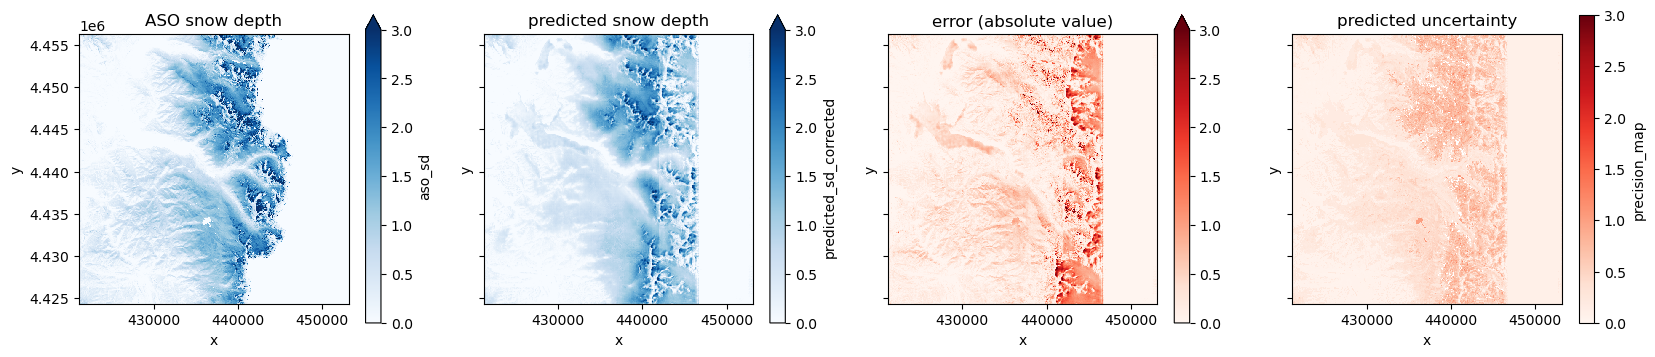

In [13]:
f, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True, sharey=True)
ds.aso_sd.plot(cmap='Blues', vmin=0, vmax=3, ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_title('ASO snow depth')
ds.predicted_sd_corrected.plot(cmap='Blues', vmin=0, vmax=3, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_title('predicted snow depth')
np.fabs(ds.aso_sd - ds.predicted_sd_corrected).plot(cmap='Reds', vmin=0, vmax=3, ax=ax[2])
ax[2].set_aspect('equal')
ax[2].set_title('error (absolute value)')
ds.precision_map.plot(cmap='Reds', vmin=0, vmax=3, ax=ax[3])
ax[3].set_aspect('equal')
ax[3].set_title('predicted uncertainty')